In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import logging
import tensorflow as tf
from sklearn.model_selection import train_test_split
import unicodedata
import time
import warnings
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.getLogger('tensorflow').setLevel(logging.FATAL)

# Display matplotlib plots inline in notebooks
%matplotlib inline

# Define the path to the dataset
PATH = "/content/Hindi_English_Truncated_Corpus.csv"


for dirname, _, filenames in os.walk('/content'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

try:
    # Specify the encoding as 'latin-1' or 'ISO-8859-1'
    dataset = pd.read_csv(PATH, encoding='latin-1')
    print("Dataset loaded successfully!")
    print(dataset.head())  # Display the first few rows for verification
except FileNotFoundError:
    print(f"File not found at the path: {PATH}. Please check the file location.")
except UnicodeDecodeError:
    print(f"UnicodeDecodeError: Could not decode the file with 'latin-1'. Try another encoding like 'ISO-8859-1' or 'utf-16'.")



/content/Hindi_English_Truncated_Corpus.csv
/content/.config/active_config
/content/.config/gce
/content/.config/.last_opt_in_prompt.yaml
/content/.config/.last_survey_prompt.yaml
/content/.config/config_sentinel
/content/.config/default_configs.db
/content/.config/hidden_gcloud_config_universe_descriptor_data_cache_configs.db
/content/.config/.last_update_check.json
/content/.config/configurations/config_default
/content/.config/logs/2024.11.25/19.13.09.316504.log
/content/.config/logs/2024.11.25/19.12.20.690274.log
/content/.config/logs/2024.11.25/19.12.56.407212.log
/content/.config/logs/2024.11.25/19.13.10.119162.log
/content/.config/logs/2024.11.25/19.12.42.183555.log
/content/.config/logs/2024.11.25/19.12.55.136430.log
/content/drive/MyDrive/ConfirmationPage_210310133130.pdf
/content/drive/MyDrive/01.mpg
/content/drive/MyDrive/Screenshot_20220710_151940.jpg
/content/drive/MyDrive/Screenshot_20221213_082232.jpg
/content/drive/MyDrive/IMG_20230610_111607.jpg
/content/drive/MyDrive/

In [ ]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    w = w.rstrip().strip()
    return w

def hindi_preprocess_sentence(w):
    w = w.rstrip().strip()
    return w

In [ ]:
def create_dataset(path=PATH):
    lines=pd.read_csv(path,encoding='utf-8')
    lines=lines.dropna()
    lines = lines[lines['source']=='ted']
    en = []
    hd = []
    for i, j in zip(lines['english_sentence'], lines['hindi_sentence']):
        en_1 = [preprocess_sentence(w) for w in i.split(' ')]
        en_1.append('<end>')
        en_1.insert(0, '<start>')
        hd_1 = [hindi_preprocess_sentence(w) for w in j.split(' ')]
        hd_1.append('<end>')
        hd_1.insert(0, '<start>')
        en.append(en_1)
        hd.append(hd_1)
    return hd, en

In [ ]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [ ]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
  lang_tokenizer.fit_on_texts(lang)
  tensor = lang_tokenizer.texts_to_sequences(lang)
  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,padding='post')
  return tensor, lang_tokenizer

In [ ]:
def load_dataset(path=PATH):
    targ_lang, inp_lang = create_dataset(path)
    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)
    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [ ]:
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(PATH)
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

In [ ]:
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

31904 31904 7977 7977


In [ ]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
53 ----> how
8678 ----> articles
22 ----> are
4482 ----> formed
8 ----> in
6123 ----> wikipedia
14 ----> 
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
7512 ----> विकिपीडिया
5 ----> में
1832 ----> लेख
111 ----> कैसे
2066 ----> बनते
13 ----> हैं
35 ----> -
2 ----> <end>


In [ ]:


BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 128
units = 256
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    hidden_with_time_axis = tf.expand_dims(query, 1)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))
    attention_weights = tf.nn.softmax(score, axis=1)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)
    return context_vector, attention_weights

In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    context_vector, attention_weights = self.attention(hidden, enc_output)
    x = self.embedding(x)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    output, state = self.gru(x)
    output = tf.reshape(output, (-1, output.shape[2]))
    x = self.fc(output)
    return x, state, attention_weights

decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

In [ ]:
# Initialize models
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)
  mask = tf.cast(mask, dtype=loss_.dtype)
#   print(type(mask))
  loss_ *= mask
  return tf.reduce_mean(loss_)

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0
  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)
    # Teacher forcing
    for t in range(1, targ.shape[1]):
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
      loss += loss_function(targ[:, t], predictions)
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))
  variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables))
  return batch_loss

In [ ]:
#Training and Validation Loss Tracker (Extra Code Added)
train_losses = []
val_losses = []

In [ ]:
# Create checkpoint object before the training loop
checkpoint_dir = '/content/drive/MyDrive/Colab Notebooks/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [ ]:
# Training loop
EPOCHS =10

for epoch in range(EPOCHS):
    start = time.time()
    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0
    total_val_loss = 0  # Initialize total_val_loss as a float (0.0)

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss


        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, batch_loss.numpy()))


    train_loss = total_loss / steps_per_epoch
    val_loss = total_val_loss / steps_per_epoch  # Now val_loss will be a float

    train_losses.append(train_loss.numpy())  # Track training loss
    val_losses.append(val_loss)  # Append val_loss directly (no .numpy())

    # Save checkpoint every  epochs
    if (epoch + 1) == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)

    print(f"Epoch {epoch + 1} | Train Loss: {train_loss:.4f} | Validation Loss: {val_loss:.4f}")
    print(f"Time taken for 1 epoch {time.time() - start:.2f} sec")


Epoch 1 Batch 0 Loss 2.7630
Epoch 1 Batch 100 Loss 1.7664
Epoch 1 Batch 200 Loss 1.8168
Epoch 1 Batch 300 Loss 1.7889
Epoch 1 Batch 400 Loss 1.7988
Epoch 1 | Train Loss: 1.9323 | Validation Loss: 0.0000
Time taken for 1 epoch 2194.10 sec
Epoch 2 Batch 0 Loss 1.6679
Epoch 2 Batch 100 Loss 1.6771
Epoch 2 Batch 200 Loss 1.6232
Epoch 2 Batch 300 Loss 1.7162
Epoch 2 Batch 400 Loss 1.6565
Epoch 2 | Train Loss: 1.7051 | Validation Loss: 0.0000
Time taken for 1 epoch 2133.91 sec
Epoch 3 Batch 0 Loss 1.6549
Epoch 3 Batch 100 Loss 1.4863
Epoch 3 Batch 200 Loss 1.6300
Epoch 3 Batch 300 Loss 1.6121
Epoch 3 Batch 400 Loss 1.5134
Epoch 3 | Train Loss: 1.6012 | Validation Loss: 0.0000
Time taken for 1 epoch 2120.68 sec
Epoch 4 Batch 0 Loss 1.5297
Epoch 4 Batch 100 Loss 1.4776
Epoch 4 Batch 200 Loss 1.5834
Epoch 4 Batch 300 Loss 1.5774
Epoch 4 Batch 400 Loss 1.6271
Epoch 4 | Train Loss: 1.5253 | Validation Loss: 0.0000
Time taken for 1 epoch 2117.03 sec
Epoch 5 Batch 0 Loss 1.4952
Epoch 5 Batch 100 Lo

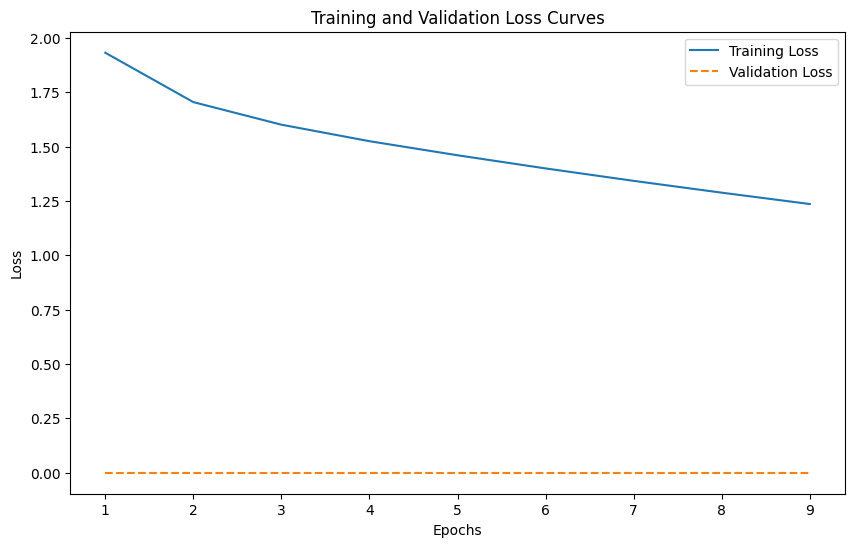

In [ ]:
#saved ephoce
train_losses = [
    1.9323, 1.7051, 1.6012, 1.5253, 1.4605, 1.4000, 1.3428, 1.2884, 1.2362
]
val_losses = [0.0] * len(train_losses)


# Visualize Training and Validation Loss Curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss", linestyle='--')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curves")
plt.legend()
plt.show()


In [ ]:
# BLEU Score Evaluation (Extra Code Added)
def evaluate_bleu(reference, candidate):
    """
    Compute BLEU score for a single translation.
    """
    reference = [reference.split()]
    candidate = candidate.split()
    smoothing_function = SmoothingFunction().method4
    score = sentence_bleu(reference, candidate, smoothing_function=smoothing_function)
    return score


In [ ]:
# Specify directory to save model weights
save_path = '/content/drive/MyDrive/Colab Notebooks/saved_model/'
if not os.path.exists(save_path):
    os.makedirs(save_path)

In [ ]:
# Save function
checkpoint.save(file_prefix=checkpoint_prefix)
encoder.save_weights(save_path + 'encoder_weights.weights.h5')
decoder.save_weights(save_path + 'decoder_weights.weights.h5')
print("Model saved successfully!")


Model saved successfully!


In [ ]:
### Check if the model weights files exist before attempting to load them
if os.path.exists('/content/drive/MyDrive/Colab Notebooks/saved_model/encoder_weights.weights.h5') and os.path.exists('/content/drive/MyDrive/Colab Notebooks/saved_model/decoder_weights.weights.h5'):
    checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
    encoder.load_weights('/content/drive/MyDrive/Colab Notebooks/saved_model/encoder_weights.weights.h5')
    decoder.load_weights('/content/drive/MyDrive/Colab Notebooks/saved_model/decoder_weights.weights.h5')
    print("Model loaded successfully!")
else:
    print("No saved model found. Starting training from scratch.")

Model loaded successfully!


In [ ]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    sentence = preprocess_sentence(sentence)
    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)
    result = ''
    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)
    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)
        predicted_id = tf.argmax(predictions[0]).numpy()
        result += targ_lang.index_word[predicted_id] + ' '
        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence
        dec_input = tf.expand_dims([predicted_id], 0)
    return result, sentence

In [ ]:
def translate(sentence, sample_translation=" क़र्ज़ ट्रेन कीड़े"):
    result, sentence = evaluate(sentence)
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
   # bleu_score = evaluate_bleu(format(result), sample_translation)
   # print(f"BLEU score for sample input: {bleu_score}")

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
translate(u'i want you to go home.')

Input: i want you to go home .
Predicted translation: ट्रेन कैमरों मुजीबा, साझी बगीचा उनकी घोड़े निलंबित ग्राफिटी भलाई ट्रेन कैमरों मुजीबा, साझी बगीचा उनकी घोड़े निलंबित ग्राफिटी भलाई ट्रेन कैमरों मुजीबा, साझी बगीचा उनकी घोड़े निलंबित ग्राफिटी भलाई ट्रेन कैमरों मुजीबा, 
